In [4]:
# from decoding import *
import pickle
import numpy as np
import cv2
import sys
import os
import matplotlib.pyplot as plt
import reedsolo as rs
import re

from decoding import get_qr_metadata
from consts import (
    MASKS,
    DIRECTION_OFFSETS,
    UP4,
    DOWN4,
    UP8,
    DOWN8,
    CW8,
    CCW8,
    QR_READ_STEPS,
    N_DIM,
)

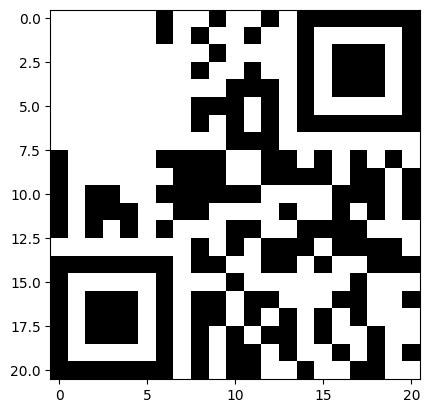

In [5]:
n_tc = 6
debug = True

images = pickle.load(
    open("/Users/ziad/Desktop/Projects/CV/preprocessing_pipeline/read_images.pkl", "rb")
)
image_name, image = images[n_tc]

plt.imshow(image, cmap="gray")

plt.show()

In [6]:
meta = get_qr_metadata(image, inverted=False)

mask = meta["mask"]

In [7]:
meta

{'ec_level': [1, 1],
 'mask': [1, 1, 1],
 'fmt_ec': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 'mask_str': '111'}

In [8]:
def apply_mask_general(
    data_start_i, data_start_j, data, direction, inverted=False, debug=False, plot=False
):
    result = []

    mask_str = get_qr_metadata(data, inverted=inverted)["mask_str"]

    offsets = DIRECTION_OFFSETS[direction]

    row_offsets = offsets["row_offsets"]
    col_offsets = offsets["col_offsets"]

    if not inverted:
        data = 1 - data

    for i, j in zip(row_offsets, col_offsets):
        x_idx = data_start_i + i
        y_idx = data_start_j + j

        if debug:
            print(f"({x_idx}, {y_idx}) -> {data[x_idx, y_idx]}")

        cell_bit = bool(data[x_idx, y_idx])
        mask_bit = MASKS[mask_str](x_idx, y_idx)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    if debug:
        print("\n\n\n")

    # show which bits were selected using the mask via matplotlib
    if plot:
        plt.imshow(1 - data, cmap="gray")
        for i, j in zip(row_offsets, col_offsets):
            x_idx = data_start_i + i
            y_idx = data_start_j + j
            plt.scatter(y_idx, x_idx, color="red")
        plt.title("Scanning with mask: " + mask_str)
        plt.show()

    return result[:4] if direction in [UP4, DOWN4] else result

In [9]:
enc_bits = apply_mask_general(
    len(image) - 1, len(image) - 1, image, UP4, inverted=False
)

enc_bits

[0, 0, 1, 0]

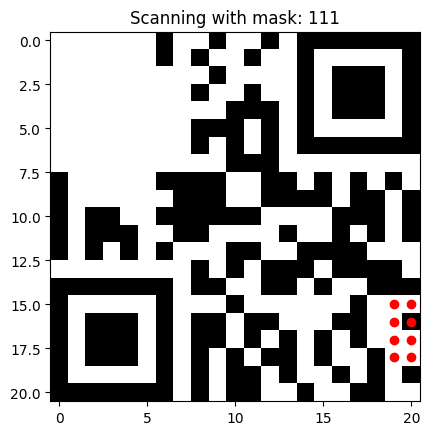

[0, 0, 0, 0, 1, 0, 0, 0]

In [10]:
len_bits = apply_mask_general(
    len(image) - 3, len(image) - 1, image, UP8, inverted=False, plot=True
)

len_bits

In [11]:
def binary_to_alphanumeric(bin_str):
    alphanumeric_chars = [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "A",
        "B",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "J",
        "K",
        "L",
        "M",
        "N",
        "O",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "U",
        "V",
        "W",
        "X",
        "Y",
        "Z",
        " ",
        "$",
        "%",
        "*",
        "+",
        "-",
        ".",
        "/",
        ":",
    ]

    # Ensure the input is an 11-bit binary string
    if len(bin_str) == 11:
        # Convert the 11-bit binary string to an integer
        value = int(bin_str, 2)

        # Calculate C1 and C2 using the formula V = 45 * C1 + C2
        C1 = value // 45
        C2 = value % 45

        # Get the corresponding characters
        char1 = alphanumeric_chars[C1]
        char2 = alphanumeric_chars[C2]

        return char1, char2

    else:
        # decode the last 6 bits
        value = int(bin_str, 2)

        char = alphanumeric_chars[value]

        return char, None


def extract_alphanum(data_bits):
    # split each 11 bits into 2 6-bit numbers
    data_chars = [data_bits[i : i + 11] for i in range(0, len(data_bits), 11)]

    all_chars = []

    all_chars = []
    for data_char in data_chars[:-1]:
        char1, char2 = binary_to_alphanumeric(data_char)
        all_chars.append(char1)
        all_chars.append(char2)

    # decode the last 6 bits
    char, _ = binary_to_alphanumeric(data_chars[-1])

    all_chars.append(char)

    return "".join(all_chars)

In [12]:
def exec():
    enc_bits = apply_mask_general(
        len(image) - 1, len(image) - 1, image, UP4, inverted=False
    )

    len_bits[0] = 0
    len_bits[1] = 0

    len_ = int("".join([str(bit) for bit in len_bits]), 2)

    if debug:
        print("Enc bits", enc_bits)
        print("Len bits", len_bits, len_)

    msg_bits = []
    msg_bits.extend(enc_bits)
    msg_bits.extend(len_bits)

    chars = []

    idx = 0

    # read the first len_ blocks
    for _ in range(min(len_, 18)):
        start_i, start_j, direction = QR_READ_STEPS[idx]
        bits = apply_mask_general(start_i, start_j, image, direction, inverted=False)
        msg_bits.extend(bits)
        bit_str = "".join([str(bit) for bit in bits])
        # alpha_char = chr(int(bit_str, 2))
        # chars.append(alpha_char)
        if debug:
            print(f"{bit_str} (={int(bit_str, 2):03d})")
        idx += 1

    # read the end block
    start_i, start_j, direction = QR_READ_STEPS[idx]
    bits = apply_mask_general(start_i, start_j, image, direction, inverted=False)
    msg_bits.extend(bits)
    idx += 1

    # read the rest of the blocks
    for _ in range(len(QR_READ_STEPS) - len_ - 1):
        start_i, start_j, direction = QR_READ_STEPS[idx]
        bits = apply_mask_general(start_i, start_j, image, direction, inverted=False)
        bit_str = "".join([str(bit) for bit in bits])
        # alpha_char = chr(int(bit_str, 2))
        if debug:
            print(f"{bit_str} (={int(bit_str, 2):03d})")

        msg_bits.extend(bits)
        idx += 1

    bit_stream = "".join(str(b) for b in msg_bits)

    if debug:
        print("Msg bits: ", "".join(str(k) for k in msg_bits), end="\t")

    # print("".join(chars))
    enc_str = "".join([str(bit) for bit in enc_bits])
    if debug:
        print("ENC_STR: ", enc_str)
    if enc_str == "0100":
        enc_type = "byte"
    elif enc_str == "0010":
        enc_type = "alphanum"
    else:
        raise ValueError(f"Unsupported encoding type: {enc_str}")

    if enc_type == "alphanum":
        data_bits = bit_stream[13:]

        message = extract_alphanum(data_bits[: len_ * 11 + 6])

        print(f"Data in message = {message}")

        return

    message_bytes = [
        int("".join(map(str, msg_bits[i : i + 8])), 2)
        for i in range(0, len(msg_bits), 8)
    ]

    if debug:
        print("Message bytes", message_bytes)

    # Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
    rsc = rs.RSCodec(nsym=7)

    # Decode the bytes with the 7-ECC RS Codec
    # find n errors
    try:
        message_decoded = rsc.decode(message_bytes)
        rsc.maxerrata(verbose=False)

        # In order to extract the actual data, need to convert back to bits
        # Then take as many bytes as indicated by the message length indicator
        # That is AFTER removing the first 12 bytes (of enc and len)
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder="big"))[
            13 : 13 + len_ * 8
        ]

        # Now convert back to bytes and print it lol
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits) + 7) // 8, "big")
        print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
    except rs.ReedSolomonError as e:
        msg_str = "".join(chars)

        msg_removed_illegal_chars = re.sub(r"[^\x00-\x7F]", "", msg_str)

        msg_raw_new_lines_removed = re.sub(r"[\r\n]", "", msg_removed_illegal_chars)

        print(f"Error decoding message: {e}, message = {msg_raw_new_lines_removed}")

In [13]:
debug = False

In [11]:
exec()

Data in message = THE MIGHTY FINGER


In [14]:
def extract_alphanum(data_bits):
    # split each 11 bits into 2 6-bit numbers
    data_chars = [data_bits[i : i + 11] for i in range(0, len(data_bits), 11)]

    all_chars = []
    for i, char in enumerate(data_chars):
        if i == len(data_chars) - 1:
            char1, _ = binary_to_alphanumeric(char)
            all_chars.append(char1)
        else:
            char1, char2 = binary_to_alphanumeric(char)
            all_chars.append(char1)
            all_chars.append(char2)

    return "".join(all_chars)

In [15]:
x = "0010000010001101001010100101001101001111110000010111000011010011101111001100011011010000010101101111001101100000111011000001000111101100000100011110110000100111110011000011111100111111000001011101011000000000"
y = "0010000010001101001010100101001101001111110000010111000011010011101111001100011011010000010101101111001101100000111011000001000111101100000100011110110000100111110011000011111100111111000001011101011000000000"
z = "0010000010001101001010100101001101001111110000010111000011010011101111001100011011010000010101101111001101100000111011000001000111101100000100011110110000100111110011000011111100111111000001011101011000000000"
l = "1010010101001010011010011111100000101110000110100111011110011000"
gt = "101001010100101001101001111110000010111000011010011101111001100011011010000010101101111001101100000111011000001000111101100000100011110110000100111110011000011111100111111000001011101011000000000"
data_bits = l

# get chunks of 11 bits
data_chars = [data_bits[i : i + 11] for i in range(0, len(data_bits), 11)]

all_chars = []
for data_char in data_chars[:]:
    char1, char2 = binary_to_alphanumeric(data_char)
    all_chars.append(char1)
    if char2:
        all_chars.append(char2)

message = "".join(all_chars)

print(message)

# all_chars = []
# for i, char in enumerate(data_chars):
#     if i == len(data_chars) - 1:
#         char1, _ = binary_to_alphanumeric(char)
#         all_chars.append(char1)
#     else:
#         char1, char2 = binary_to_alphanumeric(char)
#         all_chars.append(char1)
#         all_chars.append(char2)

# print(
#     f'Data in message = "{"".join(all_chars)}"'
# )

IndexError: list index out of range

In [16]:
len(l)

64

In [14]:
len(gt) - 6 / 11

194.45454545454547

In [15]:
x = "0010000010001"
len(x)

13

In [16]:
enc_mode = bit_stream[:4]
len_bits = bit_stream[4:12]
len_ = int(len_bits, 2)

print("LEN", len_)
data_bits = bit_stream[12:]

if enc_mode == "0100":
    print("Byte encoding mode")

    len_ = int(len_bits, 2)

    data_bytes = int(data_bits, 2).to_bytes((len(data_bits) + 7) // 8, "big")

    print(f"Data bytes: {data_bytes}")
elif enc_mode == "0010":
    print("Alphanumeric encoding mode")

    len_ = int(len_bits, 2)

    # split each 11 bits into 2 6-bit numbers
    data_chars = [data_bits[i : i + 11] for i in range(0, len(data_bits), 11)]

    # convert each 11-bit number to two 6-bit numbers
    data_nums = [int(data_char[:6], 2) for data_char in data_chars]

    # convert each 6-bit number to the corresponding alphanumeric character
    data_chars = [chr(num) for num in data_nums]

    # join the characters to form the data string
    data_str = "".join(data_chars)

    print(f"Data string: {data_str}")

NameError: name 'bit_stream' is not defined

In [ ]:
all_chars = []

len_ = int(len_bits, 2)

# skip the first 12 bits
data_bits = data_bits[12:]

# split each 11 bits into 2 6-bit numbers
data_chars = [data_bits[i : i + 11] for i in range(0, len(data_bits), 11)]

# convert each 11-bit number to two 6-bit numbers
# for entry in data_chars:


# # convert each 11-bit number to two 6-bit numbers
# data_nums = [int(data_char[:6], 2) for data_char in data_chars]

# # convert each 6-bit number to the corresponding alphanumeric character
# data_chars = [chr(num) for num in data_nums]

# # join the characters to form the data string
# data_str = "".join(data_chars)

print(f"Data string: {data_chars}")

Data string: ['01010011010', '01111110000', '01011100001', '10100111011', '11001100011', '01101000001', '01011011110', '01101100000', '11101100000', '10001111011', '00000100011', '11011000010', '01111100110', '00011111100', '11111100000', '10111010110', '00000000']


In [ ]:
vals = [
    "01010011010",
    "01111110000",
    "01011100001",
    "10100111011",
    "11001100011",
    "01101000001",
    "01011011110",
    "01101100000",
    "11101100000",
    "10001111011",
    "00000100011",
    "11011000010",
    "01111100110",
    "00011111100",
    "11111100000",
    "10111010110",
    "00000000",
]

"".join(vals)

'0101001101001111110000010111000011010011101111001100011011010000010101101111001101100000111011000001000111101100000100011110110000100111110011000011111100111111000001011101011000000000'

In [ ]:
all_chars = []
for data_char in vals[:-1]:
    char1, char2 = binary_to_alphanumeric(data_char)
    all_chars.append(char1)
    all_chars.append(char2)

message = "".join(all_chars)

print(message)

E MIGHTY FINGEJ9-/PM0Z%KM85R: X9


In [ ]:
"".join(all_chars)

'$K7IB988$S+-W0U-9RK:CXN6-:B42 MIGR'